# 📈 Bitcoin Price Prediction Using LSTM
This notebook builds an LSTM-based Recurrent Neural Network to predict Bitcoin prices using historical data.

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 📊 2. Load the Dataset
We read historical Bitcoin data and preview the latest records.

In [2]:
# Load the dataset
bitcoin_data = pd.read_csv('....\\Documents\\BitCoin_Minor_3-2\\BTC-USD_1.csv')
bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date'], format='%Y-%m-%d')
bitcoin_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2440,2021-05-23,37531.449219,38289.218750,31227.339844,34770.582031,34770.582031,78469274361
2441,2021-05-24,34700.363281,39835.140625,34551.082031,38705.980469,38705.980469,67359584098
2442,2021-05-25,38795.781250,39776.351563,36581.429688,38402.222656,38402.222656,56211915803
2443,2021-05-26,38392.625000,40782.078125,37905.835938,39294.199219,39294.199219,51346735160
2444,2021-05-27,39316.890625,40379.617188,37247.902344,38436.968750,38436.968750,43210968721


# 🧹 3. Data Preprocessing
We split the data into training and testing sets based on date and remove unnecessary columns.

In [3]:
# Split into training and testing sets
bitcoin_data_training = bitcoin_data[bitcoin_data['Date'] < '2020-01-01'].copy()
bitcoin_data_testing = bitcoin_data[bitcoin_data['Date'] >= '2020-01-01'].copy()

# Drop columns not used for training
training_data = bitcoin_data_training.drop(['Date', 'Adj Close'], axis=1)

# Apply MinMax Scaling
scaler = MinMaxScaler()
scaled_training_data = scaler.fit_transform(training_data)

# Prepare sequences
X_train, Y_train = [], []
for i in range(60, scaled_training_data.shape[0]):
    X_train.append(scaled_training_data[i-60:i])
    Y_train.append(scaled_training_data[i, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

X_train shape: (1872, 60, 5)
Y_train shape: (1872,)


# 🧠 4. Build the LSTM Model
We use an LSTM layer followed by a dropout and dense layer to predict Bitcoin prices.

In [4]:
# Initialize the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display model architecture
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11251 (43.95 KB)
Trainable params: 11251 (43.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 🏋️ 5. Train the LSTM Model
We train the model using training data with 20 epochs and a batch size of 50, reserving 10% for validation.

In [5]:
# Train the model
history = model.fit(X_train, Y_train, epochs=20, batch_size=50, validation_split=0.1)

Epoch 1/20

34/34 [==============================] - 5s 51ms/step - loss: 0.0220 - val_loss: 0.0022
Epoch 2/20
34/34 [==============================] - 1s 35ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 3/20
34/34 [==============================] - 1s 35ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 4/20
34/34 [==============================] - 1s 38ms/step - loss: 0.0022 - val_loss: 8.5028e-04
Epoch 5/20
34/34 [==============================] - 1s 34ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 6/20
34/34 [==============================] - 1s 39ms/step - loss: 0.0017 - val_loss: 9.0967e-04
Epoch 7/20
34/34 [==============================] - 1s 35ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 8/20
34/34 [==============================] - 1s 36ms/step - loss: 0.0013 - val_loss: 7.0745e-04
Epoch 9/20
34/34 [==============================] - 2s 57ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 10/20
34/34 [==============================] - 2s 52ms/step - loss: 0.0015 - val_loss: 5.4

# 📉 6. Visualize Training and Validation Loss
This helps us understand if the model is learning steadily and not overfitting.

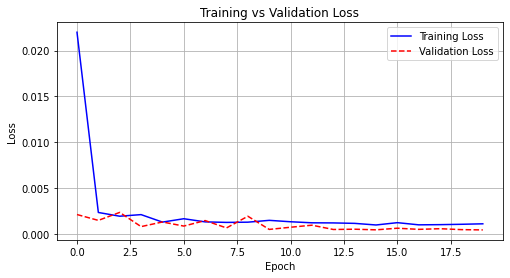

In [6]:
# Plot the training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# 🧪 7. Prepare Test Data and Make Predictions
We combine the last 60 days of training data with the test data to create proper input sequences for prediction.

In [7]:
# Combine last 60 days of training data with test data
last_60_days = bitcoin_data_training.tail(60)
combined_data = pd.concat([last_60_days, bitcoin_data_testing], ignore_index=True)
combined_data = combined_data.drop(['Date', 'Adj Close'], axis=1)

# Scale combined input
scaled_combined_data = scaler.transform(combined_data)

# Create test sequences
X_test, Y_test = [], []
for i in range(60, scaled_combined_data.shape[0]):
    X_test.append(scaled_combined_data[i-60:i])
    Y_test.append(scaled_combined_data[i, 0])

X_test, Y_test = np.array(X_test), np.array(Y_test)

print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_test shape: (513, 60, 5)
Y_test shape: (513,)


# 🔮 8. Predict and Inverse Transform
We predict Bitcoin prices using the trained model and convert the results back to original price scale.

In [8]:
# Make predictions on test data
Y_pred = model.predict(X_test)

# Inverse scaling
scaling_factor = 1 / scaler.scale_[0]  # Only for 'Open' price column
Y_pred = Y_pred * scaling_factor
Y_test = Y_test * scaling_factor

print("Predicted shape:", Y_pred.shape)

17/17 [==============================] - 1s 13ms/step
Predicted shape: (513, 1)


# 📈 9. Visualize Predicted vs Real Prices
We compare the real Bitcoin prices with those predicted by the LSTM model.

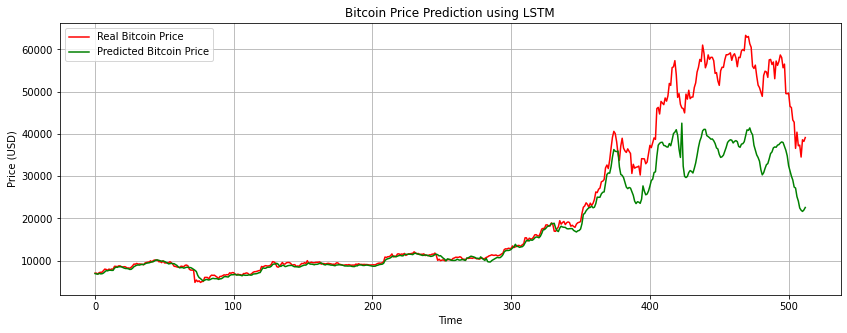

In [9]:
plt.figure(figsize=(14, 5))
plt.plot(Y_test, color='red', label='Real Bitcoin Price')
plt.plot(Y_pred, color='green', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# 📊 10. Evaluate Model Performance
We evaluate the LSTM model using common regression metrics: MAE, MSE, RMSE, and R² Score.

In [10]:
import numpy as np

# Flatten arrays just in case
y_true = Y_test.flatten()
y_pred = Y_pred.flatten()

# Calculate evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 4484.22
Mean Squared Error (MSE): 70947708.00
Root Mean Squared Error (RMSE): 8423.05
R² Score: 0.7793


Areas to Improve:

1. Increasing model complexity (more LSTM layers or units).

2. Tuning hyperparameters (batch size, learning rate).

3. Adding more features (volume, technical indicators).